In [149]:
import pandas as pd
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pystan_utils
import os
import seaborn as sn
from  movie_recommendation_aux import *
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preperation

In [6]:
seed = 42
#dataset = 'ml-20m' #big
dataset = 'ml-latest-small' #small
ratings = pd.read_csv(os.path.join(dataset,'ratings.csv'))
# HACK -- small movies.csv is apararently missing movies from small ratings.csv
movies = pd.read_csv(os.path.join('ml-20m','movies.csv')) 
#Create like column
ratings['like'] = (ratings.rating >= 3.0 )+ 0

Data samples

In [7]:
ratings.head()

,userId,movieId,rating,timestamp,like
0,1,1,4.0,964982703,1
1,1,3,4.0,964981247,1
2,1,6,4.0,964982224,1
3,1,47,5.0,964983815,1
4,1,50,5.0,964982931,1


For now instead of multiclass classification based on stars, turn problem into binary classification by defining 'like' for all movies rated 3.0 stars or above, and 'not-like' for all movies below 3.0.

For each user split sample (without replacement) 90% of data as training data and the remaining 10% as validation data. As some movies might never be sampled in the training set, remove those films from the validation set.

In [8]:
val_size = 0.3
#For sample randomly the validation set (note some movies might never be sampled)
val_set = ratings.groupby('userId').apply(lambda g: g.sample(frac=val_size,random_state=seed))
val_set.index =  val_set.index.droplevel()
#train set is compliment of val_set
train_set = ratings[~ratings.isin(val_set).all(1)]
#Possibly remove movies from validation set that was never sampled in the dataset
val_set = val_set[val_set.movieId.isin(train_set.movieId)] 

Make sure that not too many samples was removed. Fraction of the removed data is:

In [9]:
(len(ratings) - (len(train_set)+len(val_set)))/len(ratings)

0.013596334642389622

As the movieIds does not necesarrily correspond to integer indices, make new ids such that they can be used as indices in stan vectors/matrixes:

In [10]:
unique_keys = train_set.movieId.unique()
indices = range(1,len(unique_keys)+1)
movie_id_dict = dict(zip(unique_keys, indices ))
id_movie_dict = dict(zip(indices, unique_keys))
train_set['movieIdNoHoles'] = train_set['movieId'].apply(lambda movie_id: movie_id_dict[movie_id])
val_set['movieIdNoHoles'] = val_set['movieId'].apply(lambda movie_id: movie_id_dict[movie_id])

/zhome/30/0/70339/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Model

### Generative Process

```
for (userId, movieId) in [(u1,m1),(u2,m2),...,(uN,mN)]
    affinity = 0;
    for (t in 1:num_traits){
        traitAffinity = trait[movieId, t] * preference[userId, t];
        affinity += traitAffinity
    generate prediction such that prediction ~ bernoulli_logit(affinity);
```

Probably summing the trait affinities and using the affinity as logit is not the way to discrimitate between likes.

### PGM

![alt text](figs/PGM.png "Title")
*PGM of model. We use the notation of http://www.mbmlbook.com that specifices the pgm as a bipartite graph where the squares explicitely denotes the distribution* 

### STAN

In [110]:
model_definition = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int likes_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    
} 

model {
    real affinity;
    //fix symmetries
    /*for(i in 1:num_traits){
        for( j in 1:num_traits){
            if(i == j){
                trait[i,j] ~ normal(1,0.0001);
            }
            else{
                trait[i,j] ~ normal(0,0.0001);
            }
        }
    }
    */
    for (n in 1:num_likes){
        affinity = 0;
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        for (t in 1:num_traits){
            preference[userId_obs[n], t] ~ normal(0,10);
            //if (movieId_obs[n] > num_traits){
                trait[movieId_obs[n], t] ~ normal(0,10);
            //}
            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        likes_obs[n] ~ bernoulli_logit(affinity);

    }
}

generated quantities {
    int predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = bernoulli_logit_rng(affinity);
    }
}
"""

In [111]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code = model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_485b6572e43041ed88c0c6e617e0e39e NOW.


CPU times: user 1.35 s, sys: 196 ms, total: 1.54 s
Wall time: 53.5 s


# Sanity checks

### Simple data set
Generate a simple data containing two groups (p1,p2) of people and to groups of movies (m1,m2).
* p1 likes all movies in m1 but dislikes all movies in m2.
* p2 likes all movies in m2 but dislikes all movies in m1.

In [112]:
train_set_fake, val_set_fake = generate_fake_data()

In [113]:
data_fake, num_users_fake, num_movies_fake = generate_data_dict(train_set_fake, val_set_fake,n_traits=2)

In [114]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_fake = sm.vb(data=data_fake)

CPU times: user 768 ms, sys: 13.9 ms, total: 782 ms
Wall time: 777 ms


In [115]:
predictions_fake = pystan_utils.vb_extract_variable(fit_fake, 'predictions', var_type='vector', dims=[len(val_set_fake)])
get_precision(predictions_fake,val_set_fake)

1.0

The precision is 1.0 which shows that we can predict the two groups accurately.

In [116]:
preferences_fake=pystan_utils.vb_extract_variable(fit_fake, 'preference[', var_type='matrix', dims=[num_users_fake,2])
traits_fake=pystan_utils.vb_extract_variable(fit_fake, 'trait[', var_type='matrix', dims=[num_movies_fake,2])

<IPython.core.display.Javascript object>


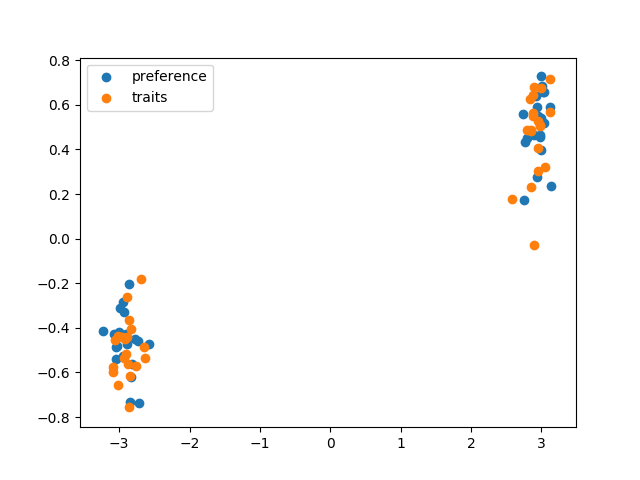

In [117]:
plt.figure()
plt.scatter(preferences_fake[:,0], preferences_fake[:,1],label='preference')
plt.scatter(traits_fake[:,0], traits_fake[:,1], label='traits')
plt.legend()

The preference and traits are nicely separated.

# Results

In [118]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2)

In [119]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit = sm.vb(data=data)

CPU times: user 1min 8s, sys: 1.83 s, total: 1min 9s
Wall time: 1min 9s


In [120]:
predictions = pystan_utils.vb_extract_variable(fit, 'predictions', var_type='vector', dims=[len(val_set)])
get_precision(predictions,val_set)

0.7746103221337028

The precision is larger than random.

## Show preferences
Here the latent traits and preferences 

In [121]:
preferences=pystan_utils.vb_extract_variable(fit, 'preference[', var_type='matrix', dims=[num_users,2])
traits=pystan_utils.vb_extract_variable(fit, 'trait[', var_type='matrix', dims=[num_movies,2])

<IPython.core.display.Javascript object>


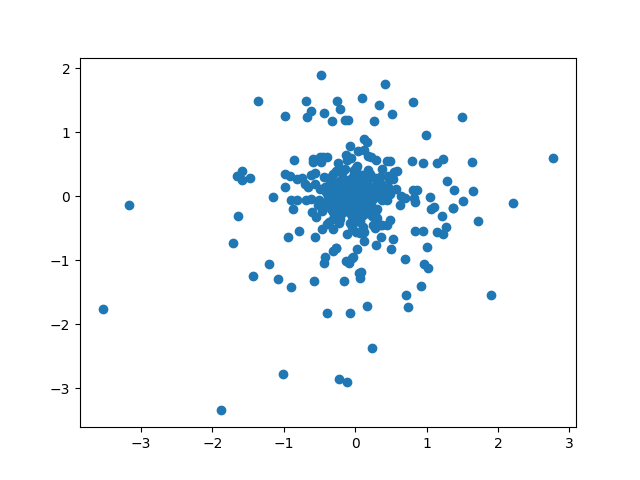

In [122]:
plt.figure()
plt.scatter(preferences[:,0], preferences[:,1])

<IPython.core.display.Javascript object>


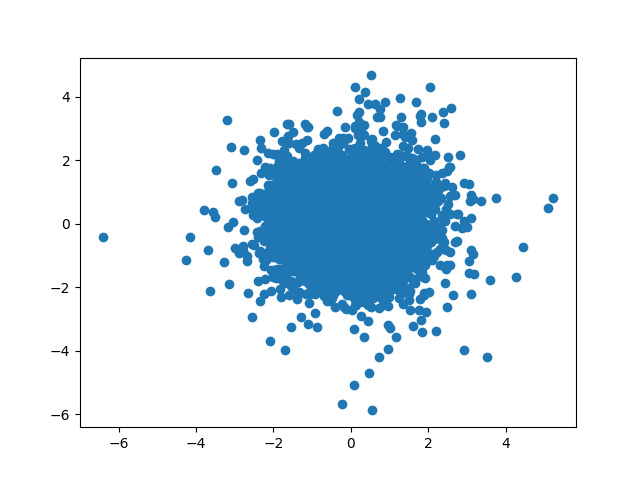

In [123]:
plt.figure()
plt.scatter(traits[:,0], traits[:,1])

It is noted that the plot is a little bit misleading as there are no guarentee that the traits are orthogonal.

Lets plot some extreme values of trait0. We would expect to see that the trait is discriminating between films using a latent trait of the film.

In [125]:
n_extreme = 10
sorted_trait_0_ids = np.argsort(traits[:,0])
lowest_ids = sorted_trait_0_ids[:n_extreme]
highest_ids = sorted_trait_0_ids[-n_extreme:]
lowest_movie_ids = [ id_movie_dict[lowest_id] for lowest_id in lowest_ids]
highest_movie_ids = [ id_movie_dict[highest_id] for highest_id in highest_ids]

In [126]:
movies[movies.movieId.isin(lowest_movie_ids)]

,movieId,title,genres
823,838,Emma (1996),Comedy|Drama|Romance
2453,2538,Dancemaker (1998),Documentary
2481,2566,Doug's 1st Movie (1999),Animation|Children
2754,2840,Stigmata (1999),Drama|Thriller
7200,7312,"Follow Me, Boys! (1966)",Comedy|Drama
9658,31184,Appleseed (Appurushîdo) (2004),Action|Animation|Fantasy|Sci-Fi
13174,63992,Twilight (2008),Drama|Fantasy|Romance|Thriller
23736,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi


In [128]:
movies[movies.movieId.isin(highest_movie_ids)]

,movieId,title,genres
2329,2414,Young Sherlock Holmes (1985),Action|Adventure|Children|Fantasy|Mystery|Thri...
2339,2424,You've Got Mail (1998),Comedy|Romance
2765,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
3584,3675,White Christmas (1954),Comedy|Musical|Romance
5085,5181,Hangar 18 (1980),Action|Sci-Fi|Thriller
5529,5628,Wasabi (2001),Action|Comedy|Crime|Drama|Thriller
6139,6238,Green Card (1990),Comedy|Drama|Romance
7546,7899,Master of the Flying Guillotine (Du bi quan wa...,Action
7921,8604,Taxi (1998),Action|Comedy
9627,31038,Smooth Talk (1985),Drama|Romance


By visual inspection of the low/high scoring, we cannot really see any latent trait that is used for discriminating.

Similar films should have similiar trait values. Therefore LOTR movies are inspected. 

<IPython.core.display.Javascript object>


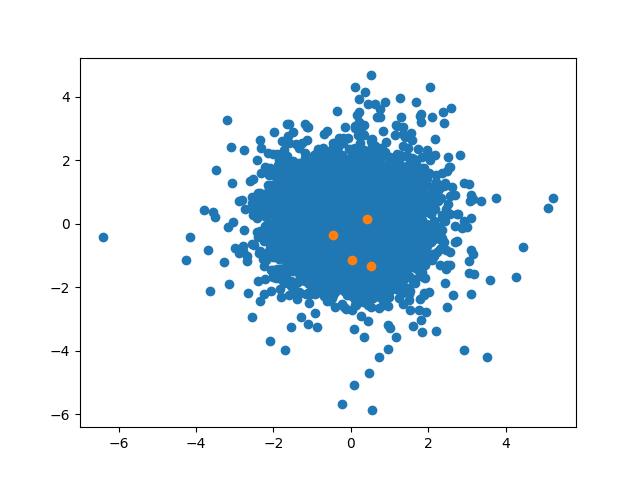

In [141]:
ids_lotr = [movie_id_dict[movie] for movie in  movies[movies.title.str.contains('Lord of the Rings')].movieId]
plt.figure()
plt.scatter(traits[:,0], traits[:,1])
plt.scatter(traits[ids_lotr][:,0],traits[ids_lotr][:,1])

In [143]:
ids_lotr

[94, 565, 573, 582]

In [146]:
movie_lotr = [id_movie_dict[id_] for id_ in ids_lotr]
movies[movies.movieId.isin(movie_lotr)]

,movieId,title,genres
2032,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7041,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


Plot the 

<IPython.core.display.Javascript object>


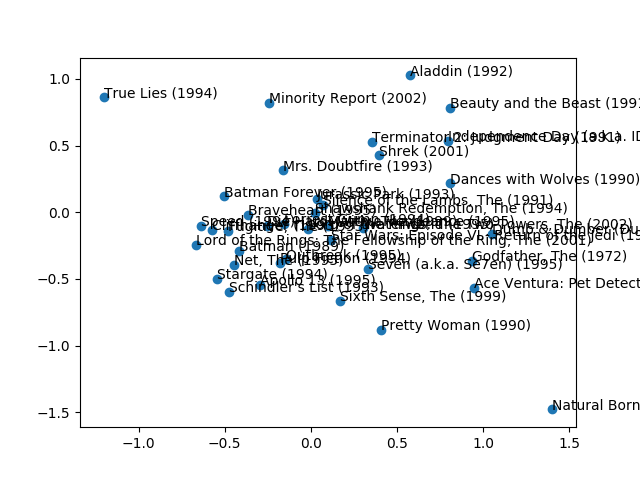

38
4993
5952


In [148]:
plot_low_variance_movies(fit,movies,num_movies,id_movie_dict)

Plotting traits and biases for some movies to see what dominates what.

<IPython.core.display.Javascript object>


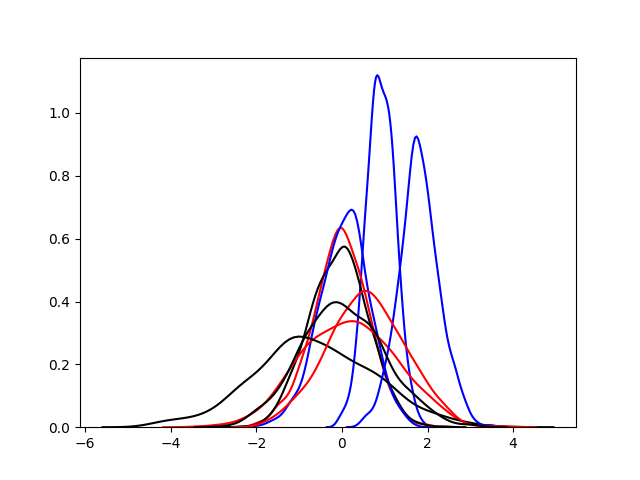

In [151]:
samples_var,means_var, stds_var, names_var=pystan_utils.vb_extract(fit)
plt.figure()
for i in range(1,4):
    sn.kdeplot(samples_var[f'trait_bias[{i}]'], color='b')
    sn.kdeplot(samples_var[f'trait[{i},1]'], color='r')
    sn.kdeplot(samples_var[f'trait[{i},2]'], color='k')

It is seen that in some cases the bias is close to zero and some 

# Questions

* *Expectation Propagation vs. Variational Bayes (10% difference in precision)?*
* *Does these values make sense (low ELBO)?*
```
Begin stochastic gradient ascent.
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -3124403.404             1.000            1.000
   200     -1131926.528             1.380            1.760
   300     -1068337.903             0.940            1.000
   400     -1037532.838             0.712            1.000
   500      -982924.262             0.581            0.060
   600     -1024784.262             0.491            0.060
   700      -967588.749             0.429            0.059
   800      -966833.896             0.376            0.059
   900      -954641.153             0.335            0.056
  1000      -932961.912             0.304            0.056
  1100      -933640.840             0.204            0.041
  1200      -944417.031             0.029            0.030
  1300      -933809.949             0.025            0.023
  1400      -922032.712             0.023            0.013
  1500      -929080.979             0.018            0.013
  1600      -923651.819             0.015            0.011
  1700      -926248.001             0.009            0.011   MEAN ELBO CONVERGED
 ```
* *Should we care about symmetries?* 
```samples_dict, means_dict, var_names = pystan_utils.vb_extract(fit2)
pystan_utils.plot_kde(samples_dict['trait[1,1]'])
```
* *Why do we not get the same values for lotr in the plots*?